## 1D stationary heat, reduced order modeling


Study reduced order modeling for the stationary heat equation
$$
\frac{d^2T}{dx^2}+\frac{E_x}{k}=0
$$
with boundary conditions $T'(0)=0$ (i.e. insulated) and $T(L)=0$ K. $E_x$ is a heat source and $k$ is the conductivity.

As the basis you have Notebooks illustrating reduced order modeling for both FEM and finite difference method. In this assignment choose to solve it with the method you prefer.

a) Implement your FEM or finite difference solver to get a high resolution solver. Assume heat source distribution like the moving "tent_distribution" in the codes for the bar problem. Assume a width of the tent $L/10$ and that it moves from left to right with a velocity $L/t_{end}$ where $L=1000$ mm and $t_{end}=1000$ s. Assume the maximum value of $E_x/k$ to be 1000 K/m$^2$. Try some different time and spatial distributions such that the results becomes "accurate enough". 

b) Based on the data from the high resolution solver in a) perform SVD analysis. In particular, give the singular values and illustrate some of the spatial modes $\mathbf{\Phi}$.

c) Now solve the problem in a) again but use reduced order modelling 
Try out different dumber of modes to check that you get convergence towards the solution you obtained by the high resolution solver in  a). 

d) Now you change the heat source to a moving Hertzian type of distribution (with the same width and maximum value as in the tent distribution). Compare the results from your high resolution solver to results from reduced order modelling. Note that you should not change the modes from b) (that are from the tent distribution loading). Compare the number of unknowns you have in reduced order modelling with your high resolution model. 

In [161]:
import numpy as np
import sympy as sp
import matplotlib
import matplotlib.cm as cm
import matplotlib.pyplot as plt

# Set up the problem

# Properties
L=1      # [m]
Exk=1000.   # [K/m^2] 
tend=1000   # [s]
Kx_max=1000    # [K/m^2]

nel=1000; #number of elements
ndofs=round(nel+1) #number of dof (number of node displacements)
Ex=np.linspace(0,L,ndofs)
dx=Ex[1]-Ex[0]

# Define Time History
tend=100
ntime=1000
# time history    
tt = np.linspace(0, tend, ntime)
dt=tt[1]-tt[0] #assume constant time step

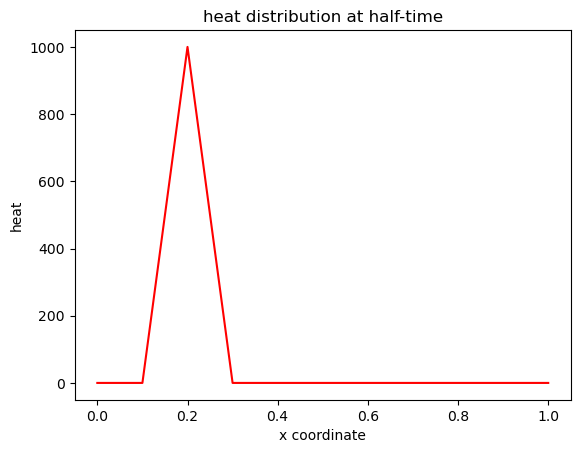

In [162]:
# a) Tent function

def tent_distribution(x, a, Kx0, velocity, time):
    """
    Computes the tent-like Kx distribution 
    
    Parameters:
    - x: grid points (x coordinates).
    - a: Load radius (half-width of the load length).
    - Kx0: Maximum Kx at the center.
    
    Returns:
    - Kx_values: Kx values at each x  point.
    """
    x0=velocity*time
    # Compute the radius from the center
    r = np.sqrt((x-x0)**2) 
    
    # Pressure distribution (Hertz formula)
    Kx_distribution = np.where(r <= a, Kx_max * (1 - r / a), 0)
    
    return Kx_distribution

###
body_width=L/10 #assume portion of the total length
velocity=L/tend #assume that the load travels the full length

#plot a figure how the temperature load looks like at half-time
heat_distribution=tent_distribution(Ex, body_width, Kx_max, velocity, tend/5)
plt.plot(Ex,heat_distribution, 'r', label='intial temperature field')
plt.xlabel('x coordinate')
plt.ylabel('heat')
plt.title('heat distribution at half-time')


A=np.zeros((ndofs-1,ndofs-1))
# Set the main diagonal to -2
np.fill_diagonal(A, -2)
# Set the upper diagonal to 1
np.fill_diagonal(A[:, 1:], 1)
# Set the lower diagonal to 1
np.fill_diagonal(A[1:, :], 1)
# Modify the last diagonal entry for the boundary condition
A[0, 0] = -1  # since du/dx=0 at x=0

A=A/(dx**2)


In [163]:
from scipy.sparse import csr_matrix
from scipy.sparse.linalg import spsolve

#use sparse matrix to speed up
As = csr_matrix(A, shape=(ndofs-1, ndofs-1))

Kx_values=np.zeros((ndofs-1,)) #initial Kx values
a_hist=np.zeros((ndofs,ntime))
for i in range(ntime):
    for j in range(ndofs-2): #note that last node has no load
        Kx_values[j]=tent_distribution(Ex[j+1], body_width, Kx_max, velocity, tt[i]) 
    #here is the solution of the unknowns in each timestep
    a=spsolve(As,-Kx_values)
    a_hist[0:-1,i]=a #save in history matrix, note that a[0] is always zero due to BC
    

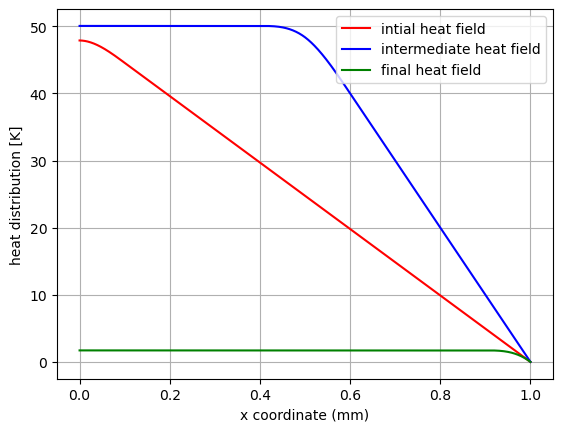

In [164]:
plt.plot(Ex,a_hist[:,0], 'r', label='intial heat field')
plt.plot(Ex,a_hist[:,round(ntime/2)], 'b', label='intermediate heat field')
plt.plot(Ex,a_hist[:,-1], 'g', label='final heat field')
plt.xlabel('x coordinate (mm)')  # Label for the x-axis
plt.ylabel('heat distribution [K]')  # Label for the y-axis
plt.legend()
plt.grid()
plt.show()

b)

Singular values: 
 [39317.04050905  4293.52465248  1494.79316895   725.46901758
   410.45223051   252.50802348   163.12697701   108.43694451
    73.18665779    49.66806061]


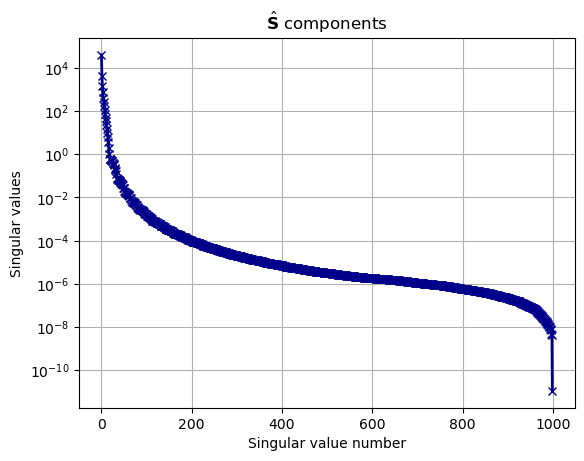

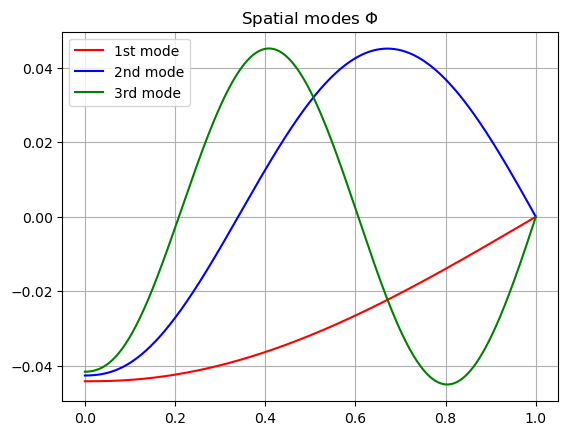

In [165]:
# b)

# Economy SVD of a_hist
X=a_hist

Uec, Sec, VTec = np.linalg.svd(X, full_matrices=False)

print('Singular values: \n', Sec[0:10])

## Plot the singular values of Shat:
fig, ax = plt.subplots()
ax.semilogy(Sec, linewidth=2.0, label='t=0', marker='x', color='darkblue')
ax.set_title(r'$\hat{\mathbf{S}}$ components')
plt.xlabel('Singular value number')
plt.ylabel('Singular values')
plt.grid()
plt.show()

plt.title(r'Spatial modes $\Phi$')
plt.plot(Ex,Uec[:,0], 'r', label='1st mode')
plt.plot(Ex,Uec[:,1], 'b', label='2nd mode')
plt.plot(Ex,Uec[:,2], 'g', label='3rd mode')
plt.grid()
plt.legend()
plt.show()

c)

(1001, 20)
(20,)


Text(0, 0.5, 'heat [K]')

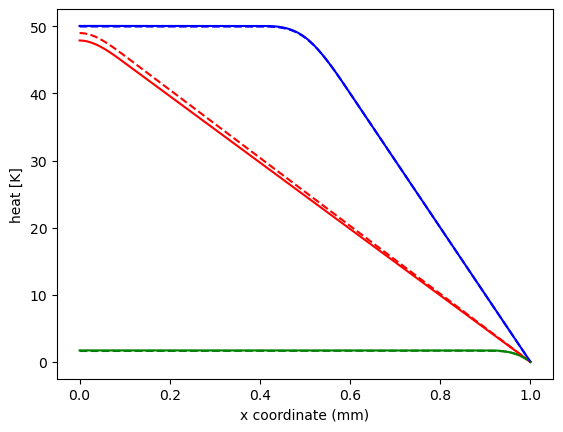

In [166]:
nr=20 # Set nr of modes here

# Extract selected nr of modes
Phi=np.zeros((ndofs,nr))
for i in range(nr):
    Phi[:,i]=Uec[:,i]

    dPhi_dx=np.zeros((ndofs,nr))
for i in range(nr):
    dPhi_dx[:,i] = np.gradient(Phi[:,i], Ex)
d2Phi_dx2=np.zeros((ndofs,nr))
for i in range(nr):
    d2Phi_dx2[:,i] = np.gradient(dPhi_dx[:,i], Ex)


# Solve for unknowns with nr. of modes
b_hist=np.zeros((nr,ntime))
from scipy import linalg
#use sparse matrix to speed up
As = csr_matrix(A, shape=(ndofs-1, ndofs-1))
Kx_values=np.zeros((ndofs,)) #initial Kx values

for i in range(ntime):
    for j in range(ndofs):
        Kx_values[j]=tent_distribution(Ex[j], body_width, Kx_max, velocity, tt[i]) 
    #Kx_values=hertz_distribution(Ex, body_width, Kx, velocity, tt[i])  #hertz_distribution(Ex[1:-1], body_width, Kx, velocity, tt[i]) 
    #print(Kx_values.shape) 
    b=np.linalg.pinv(d2Phi_dx2) @ (-Kx_values)  #nthe reason for using pinv is that we have more equations (one for each node position) than unknowns 
    b_hist[:,i]=b #save in history matrix
    


# Compute heat distribution
a_hist_red=np.zeros((ndofs,ntime))
for i in range(ntime):
    a_hist_red[:,i]=Phi @ b_hist[:,i]



print(Phi.shape)
print(b_hist[:,0].shape)

plt.plot(Ex,a_hist[:,0], 'r', label='intial displacement field')
plt.plot(Ex,a_hist[:,round(ntime/2)], 'b', label='intermediate displacement field')
plt.plot(Ex,a_hist[:,-1], 'g', label='final temperature field')


plt.plot(Ex,a_hist_red[:,0], 'r--', label='reduced model, intial displacement  field')
plt.plot(Ex,a_hist_red[:,round(ntime/2)], 'b--', label='reduced model, intermediate displacement  field')
plt.plot(Ex,a_hist_red[:,-1], 'g--', label='reduced model,final displacement  field')
plt.xlabel('x coordinate (mm)')  # Label for the x-axis
plt.ylabel('heat [K]')  # Label for the y-axis
# plt.legend()




d)

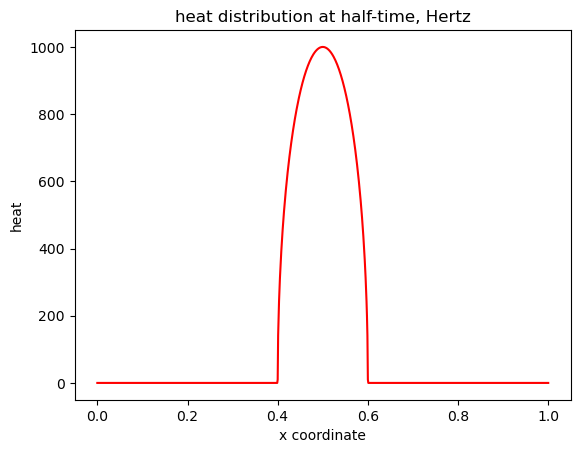

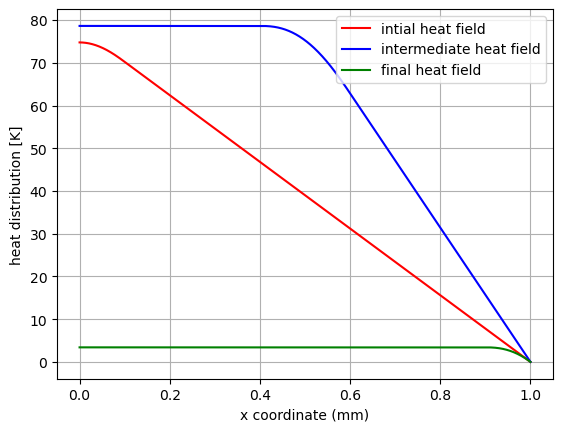

(1000,)
(1001, 20)


In [167]:
# d) Same again for Hertz

def hertz_distribution(x, a, Kx0, velocity, time):
    """
    Computes the Hertz Kx distribution 
    
    Parameters:
    - x: grid points (x coordinates).
    - a: Load radius (half-width of the load length).
    - Kx0: Maximum Kx at the center.
    
    Returns:
    - Kx_values: Kx values at each x  point.
    """
    x0=velocity*time
    # Compute the radius from the center
    r = np.sqrt((x-x0)**2) 
    
    # Pressure distribution (Hertz formula)
    Kx_distribution_HZ = np.where(r <= a, Kx0 * np.sqrt(np.abs( 1.0001 - (r / a)**2)) , 0)
    
    return Kx_distribution_HZ


#plot a figure how the temperature load looks like at half-time
heat_distribution=hertz_distribution(Ex, body_width, Kx_max, velocity, tend/2)
plt.plot(Ex,heat_distribution, 'r', label='intial temperature field')
plt.xlabel('x coordinate')
plt.ylabel('heat')
plt.title('heat distribution at half-time, Hertz')

A=np.zeros((ndofs-1,ndofs-1))
np.fill_diagonal(A, -2)
np.fill_diagonal(A[:, 1:], 1)
np.fill_diagonal(A[1:, :], 1)
A[0, 0] = -1

A=A/(dx**2)

#use sparse matrix to speed up
As = csr_matrix(A, shape=(ndofs-1, ndofs-1))

Kx_values_HZ=np.zeros((ndofs-1,))
a_hist_HZ=np.zeros((ndofs,ntime))
for i in range(ntime):
    for j in range(ndofs-2):
        Kx_values_HZ[j]=hertz_distribution(Ex[j+1], body_width, Kx_max, velocity, tt[i]) 

    a=spsolve(As,-Kx_values_HZ)
    a_hist_HZ[0:-1,i]=a


plt.figure()
plt.plot(Ex,a_hist_HZ[:,0], 'r', label='intial heat field')
plt.plot(Ex,a_hist_HZ[:,round(ntime/2)], 'b', label='intermediate heat field')
plt.plot(Ex,a_hist_HZ[:,-1], 'g', label='final heat field')
plt.xlabel('x coordinate (mm)')  # Label for the x-axis
plt.ylabel('heat distribution [K]')  # Label for the y-axis
plt.legend()
plt.grid()
plt.show()

print(Kx_values_HZ.shape)
print(d2Phi_dx2.shape)


(1001, 20)
(20,)


Text(0, 0.5, 'heat [K]')

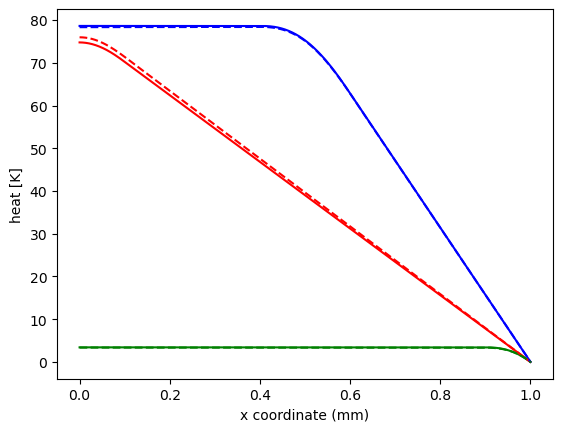

In [168]:

nr=20 # Set nr of modes here

# Extract selected nr of modes
Phi=np.zeros((ndofs,nr))
for i in range(nr):
    Phi[:,i]=Uec[:,i]

    dPhi_dx=np.zeros((ndofs,nr))
for i in range(nr):
    dPhi_dx[:,i] = np.gradient(Phi[:,i], Ex)
d2Phi_dx2=np.zeros((ndofs,nr))
for i in range(nr):
    d2Phi_dx2[:,i] = np.gradient(dPhi_dx[:,i], Ex)


# Solve for unknowns with nr. of modes
b_hist=np.zeros((nr,ntime))
from scipy import linalg
#use sparse matrix to speed up
As = csr_matrix(A, shape=(ndofs-1, ndofs-1))
Kx_values=np.zeros((ndofs,)) #initial Kx values

for i in range(ntime):
    for j in range(ndofs):
        Kx_values[j]=hertz_distribution(Ex[j], body_width, Kx_max, velocity, tt[i]) 
    #Kx_values=hertz_distribution(Ex, body_width, Kx, velocity, tt[i])  #hertz_distribution(Ex[1:-1], body_width, Kx, velocity, tt[i]) 
    #print(Kx_values.shape) 
    b=np.linalg.pinv(d2Phi_dx2) @ (-Kx_values)  #nthe reason for using pinv is that we have more equations (one for each node position) than unknowns 
    b_hist[:,i]=b #save in history matrix
    


# Compute heat distribution
a_hist_red=np.zeros((ndofs,ntime))
for i in range(ntime):
    a_hist_red[:,i]=Phi @ b_hist[:,i]



print(Phi.shape)
print(b_hist[:,0].shape)

plt.plot(Ex,a_hist_HZ[:,0], 'r', label='intial heat field')
plt.plot(Ex,a_hist_HZ[:,round(ntime/2)], 'b', label='intermediate heat field')
plt.plot(Ex,a_hist_HZ[:,-1], 'g', label='final heat field')


plt.plot(Ex,a_hist_red[:,0], 'r--', label='reduced model, intial displacement  field')
plt.plot(Ex,a_hist_red[:,round(ntime/2)], 'b--', label='reduced model, intermediate displacement  field')
plt.plot(Ex,a_hist_red[:,-1], 'g--', label='reduced model,final displacement  field')
plt.xlabel('x coordinate (mm)')  # Label for the x-axis
plt.ylabel('heat [K]')  # Label for the y-axis
# plt.legend()


